Range çözünürlüğü:   1.000 m
Azimuth çözünürlüğü: 0.250 m
Platform süpürmesi:  102.2 m
Ham veri ✓
Backprojection başlıyor...
  100/512
  200/512
  300/512
  400/512
Backprojection ✓


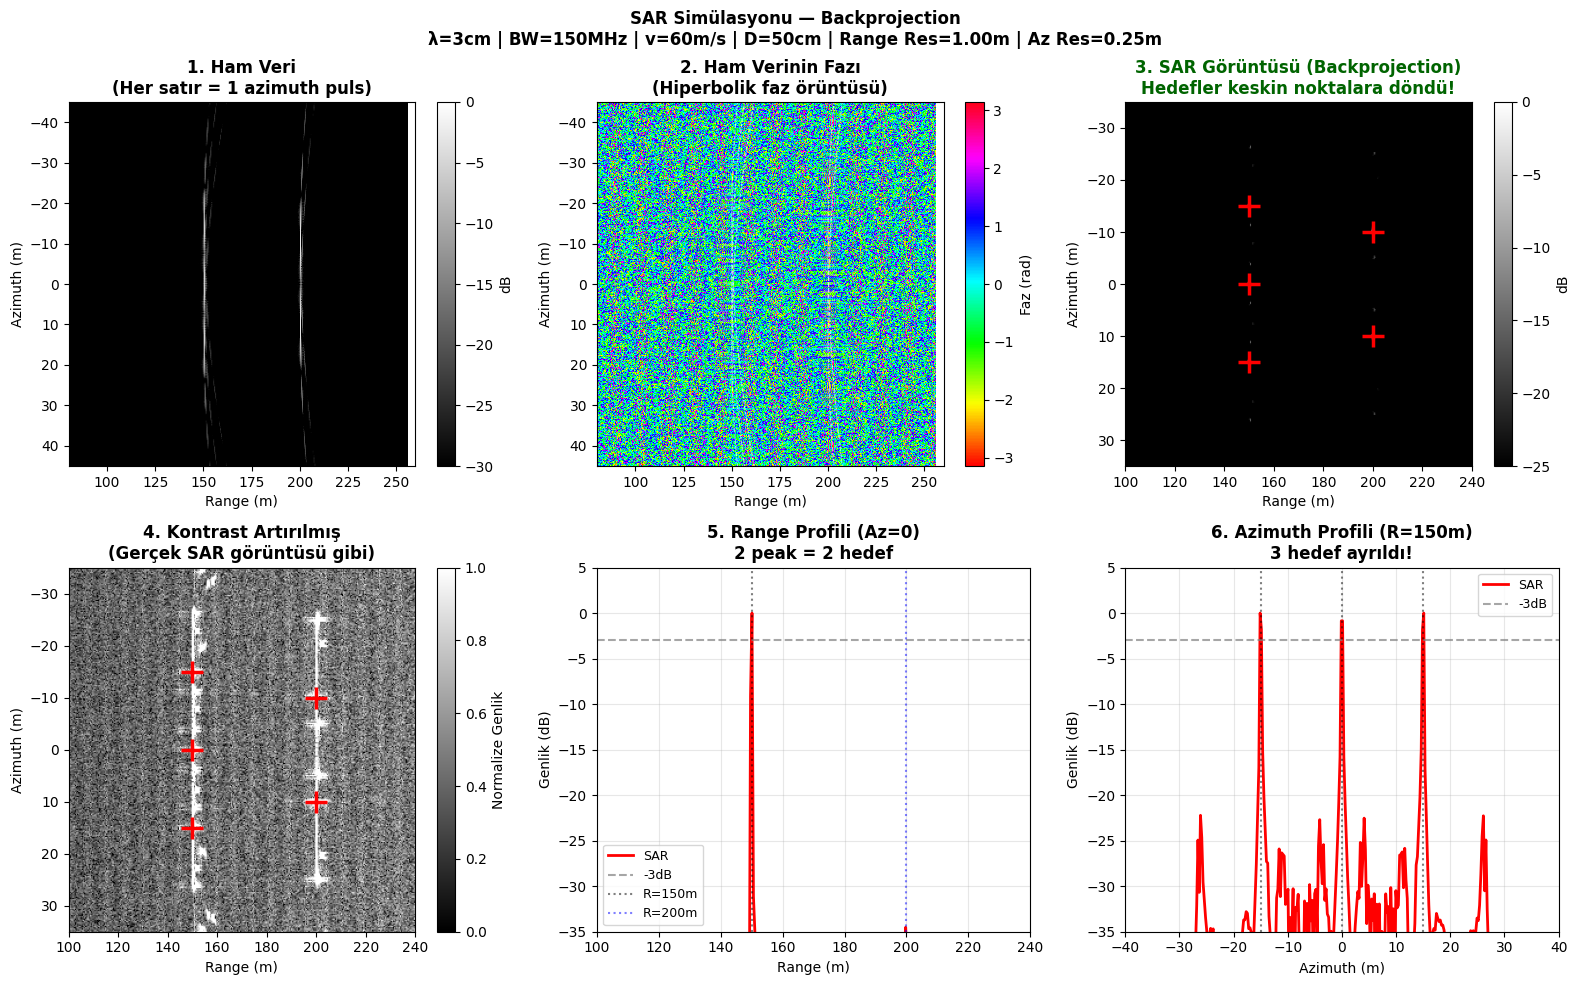

Kaydedildi!


In [4]:
"""
SAR Simülasyonu - Minimal ve Doğru
-----------------------------------
Basit faz geçmişi modeli:
s(az_idx, range_idx) = sum_k A_k * w_k * exp(-j * 4*pi/lambda * R_k(az))
                       * delta(range_idx - 2*R_k/c * fs)

Backprojection sonra bunu düzgün toplar.
"""
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PARAMETRELER
# ============================================
c     = 3e8
lam   = 0.03          # 3 cm (10 GHz)
B     = 150e6         # 150 MHz
fs    = 2 * B         # 300 MHz
PRF   = 300
v     = 60            # m/s
D_ant = 0.5           # 50 cm

N_r  = 512
N_az = 512

r_ax  = np.arange(N_r) * c / (2 * fs)   # 0 ~ 255 m
t_az  = np.arange(N_az) / PRF
y_p   = v * t_az - v * N_az / (2*PRF)   # platform pozisyonları

beamwidth = lam / D_ant   # radyan

print(f"Range çözünürlüğü:   {c/(2*B):.3f} m")
print(f"Azimuth çözünürlüğü: {D_ant/2:.3f} m")
print(f"Platform süpürmesi:  {y_p[-1]-y_p[0]:.1f} m")

# ============================================
# HEDEFLER
# ============================================
targets = [
    (150, -15, 1.0),
    (150,   0, 1.0),
    (150,  15, 1.0),
    (200, -10, 0.8),
    (200,  10, 0.8),
]

# ============================================
# HAM VERİ — Sadece faz geçmişi
# Her satır = bir azimuth pozisyonu
# Her sütun = range (zaman örnekleri)
#
# Basit model: Her azimuth pozisyonunda
# hedeften gelen sinyal = sinc(range - R_inst)
# * exp(-j*4*pi/lambda * R_inst)
# ============================================
np.random.seed(42)
raw = np.zeros((N_az, N_r), dtype=complex)

for ai, yp in enumerate(y_p):
    for (R0, az0, rcs) in targets:
        R_inst    = np.sqrt(R0**2 + (yp - az0)**2)
        r_idx_f   = 2 * R_inst / c * fs        # float range indeksi
        angle     = np.arctan2(yp - az0, R0)
        w         = rcs * np.sinc(angle / beamwidth)
        if abs(w) < 0.01:
            continue

        # Genişletilmiş sinc profili (chirp compression sonrası beklenen)
        r_vec = np.arange(N_r, dtype=float)
        # Sinc kernel: chirp bandwidth B → range res = c/(2B)
        # Normalize sinc genişliği = 1 örnek
        sinc_arg = (r_vec - r_idx_f)
        kernel   = np.sinc(sinc_arg)   # genlik profili

        # Faz: taşıyıcı frekansı * R_inst
        phase = np.exp(-1j * 4 * np.pi / lam * R_inst)

        raw[ai] += w * kernel * phase

# Hafif gürültü
raw += 5e-3 * (np.random.randn(N_az, N_r) +
               1j * np.random.randn(N_az, N_r))

print("Ham veri ✓")

# ============================================
# BACKPROJECTION
# Her piksel için azimuth boyunca topla
# ============================================
print("Backprojection başlıyor...")

r_min, r_max   = 100, 240
az_min, az_max = -35,  35
Nx = Ny = 300

r_img  = np.linspace(r_min, r_max, Nx)
az_img = np.linspace(az_min, az_max, Ny)
R_g, AZ_g = np.meshgrid(r_img, az_img)
sar = np.zeros((Ny, Nx), dtype=complex)

for ai, yp in enumerate(y_p):
    R_pix = np.sqrt(R_g**2 + (yp - AZ_g)**2)
    ang   = np.arctan2(yp - AZ_g, R_g)
    mask  = np.abs(ang) < beamwidth / 2
    if not np.any(mask):
        continue

    r_idx_f  = 2 * R_pix / c * fs
    r_floor  = np.floor(r_idx_f).astype(int)
    r_frac   = r_idx_f - r_floor
    valid    = mask & (r_floor >= 0) & (r_floor < N_r - 1)
    if not np.any(valid):
        continue

    # Bilineer interpolasyon
    v0  = raw[ai, r_floor[valid]]
    v1  = raw[ai, r_floor[valid] + 1]
    val = v0 * (1 - r_frac[valid]) + v1 * r_frac[valid]

    # Faz düzeltmesi — tam tersini uygula
    phase_corr = np.exp(1j * 4 * np.pi / lam * R_pix[valid])
    sar[np.where(valid)] += val * phase_corr

    if ai % 100 == 0:
        print(f"  {ai}/{N_az}")

print("Backprojection ✓")

# ============================================
# GÖRSELLEŞTİRME
# ============================================
def db(x, fl=-30):
    d = 20 * np.log10(np.abs(x) + 1e-12)
    d -= d.max()
    return np.clip(d, fl, 0)

ext_raw = [r_ax[0], r_ax[-1], y_p[-1], y_p[0]]
ext_bp  = [r_min, r_max, az_max, az_min]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Ham veri
ax = axes[0, 0]
im = ax.imshow(db(raw), aspect='auto', cmap='gray',
               vmin=-30, vmax=0, extent=ext_raw)
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlim([80, 260]); ax.set_ylim([45, -45])
ax.set_title('1. Ham Veri\n(Her satır = 1 azimuth puls)', fontweight='bold')
ax.set_xlabel('Range (m)'); ax.set_ylabel('Azimuth (m)')

# 2. Ham verinin faz kısmı (SAR'a özgü örüntü)
ax = axes[0, 1]
im = ax.imshow(np.angle(raw), aspect='auto', cmap='hsv',
               vmin=-np.pi, vmax=np.pi, extent=ext_raw)
plt.colorbar(im, ax=ax, label='Faz (rad)')
ax.set_xlim([80, 260]); ax.set_ylim([45, -45])
ax.set_title('2. Ham Verinin Fazı\n(Hiperbolik faz örüntüsü)', fontweight='bold')
ax.set_xlabel('Range (m)'); ax.set_ylabel('Azimuth (m)')
for (R0, az0, _) in targets:
    Rh = np.sqrt(R0**2 + (y_p - az0)**2)
    ax.plot(Rh, y_p, 'w--', lw=0.8, alpha=0.6)

# 3. SAR görüntüsü
ax = axes[0, 2]
im = ax.imshow(db(sar, fl=-25), aspect='auto', cmap='gray',
               vmin=-25, vmax=0, extent=ext_bp)
plt.colorbar(im, ax=ax, label='dB')
ax.set_title('3. SAR Görüntüsü (Backprojection)\nHedefler keskin noktalara döndü!',
             fontweight='bold', color='darkgreen')
ax.set_xlabel('Range (m)'); ax.set_ylabel('Azimuth (m)')
for (R0, az0, _) in targets:
    ax.plot(R0, az0, 'r+', ms=16, mew=2.5)

# 4. Kontrast artırılmış
ax = axes[1, 0]
mag = np.abs(sar)
p2, p98 = np.percentile(mag, [2, 98])
mag_n = np.clip((mag - p2) / (p98 - p2 + 1e-12), 0, 1) ** 0.5
im = ax.imshow(mag_n, aspect='auto', cmap='gray',
               extent=ext_bp, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label='Normalize Genlik')
ax.set_title('4. Kontrast Artırılmış\n(Gerçek SAR görüntüsü gibi)', fontweight='bold')
ax.set_xlabel('Range (m)'); ax.set_ylabel('Azimuth (m)')
for (R0, az0, _) in targets:
    ax.plot(R0, az0, 'r+', ms=16, mew=2.5)

# 5. Range profili (azimuth = 0)
ax = axes[1, 1]
az0i = np.argmin(np.abs(az_img - 0))
rp   = 20 * np.log10(np.abs(sar[az0i, :]) + 1e-12)
rp  -= rp.max()
ax.plot(r_img, rp, 'r-', lw=2, label='SAR')
ax.axhline(-3, color='gray', ls='--', alpha=0.7, label='-3dB')
ax.axvline(150, color='k',   ls=':',  alpha=0.5, label='R=150m')
ax.axvline(200, color='b',   ls=':',  alpha=0.5, label='R=200m')
ax.set_xlim([100, 240]); ax.set_ylim([-35, 5])
ax.set_xlabel('Range (m)'); ax.set_ylabel('Genlik (dB)')
ax.set_title('5. Range Profili (Az=0)\n2 peak = 2 hedef', fontweight='bold')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# 6. Azimuth profili (range = 150m)
ax = axes[1, 2]
r150i = np.argmin(np.abs(r_img - 150))
ap    = 20 * np.log10(np.abs(sar[:, r150i]) + 1e-12)
ap   -= ap.max()
ax.plot(az_img, ap, 'r-', lw=2, label='SAR')
ax.axhline(-3, color='gray', ls='--', alpha=0.7, label='-3dB')
for (R0, az0, _) in targets:
    if R0 == 150:
        ax.axvline(az0, color='k', ls=':', alpha=0.5)
ax.set_xlim([-40, 40]); ax.set_ylim([-35, 5])
ax.set_xlabel('Azimuth (m)'); ax.set_ylabel('Genlik (dB)')
ax.set_title('6. Azimuth Profili (R=150m)\n3 hedef ayrıldı!', fontweight='bold')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle(
    f'SAR Simülasyonu — Backprojection\n'
    f'λ={lam*100:.0f}cm | BW={B/1e6:.0f}MHz | v={v}m/s | D={D_ant*100:.0f}cm | '
    f'Range Res={c/(2*B):.2f}m | Az Res={D_ant/2:.2f}m',
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.savefig('SAR_simulation.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Kaydedildi!")